In [55]:
# Install external libraries
!pip install umap-learn
!pip install shap

# General libraries
import pandas as pd
import numpy as np
import os
import umap.umap_ as umap
import random as python_random
from scipy.stats import normaltest, pearsonr

# Google library
from google.colab import drive

# Graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, \
    cross_val_score

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Set seeds
umap_limit=1
seed_value=42
tf.random.set_seed(seed_value)
python_random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

# Check if gpu is enabled
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Dataset**







In [57]:
# Rosetta data
df_energy = pd.read_csv("data/binding-energy.csv", skiprows=1)

# Prodigy data
df_prodigy = pd.read_csv("data/PRODIGY_dataset.csv")

In [58]:
# Remove 'SCORE:' and 'description' column
df_energy.drop(columns=['SCORE:', 'description'], axis=1, inplace=True)

# Add experimental binding energy from Prodigy at Rosetta data
df_energy = df_energy.join(df_prodigy["DG"])

In [59]:
# Remove 'packstat' and 'yhh_planarity' because are constant
df_energy.drop(columns=['packstat', 'yhh_planarity'], axis=1, inplace=True)

df_energy.drop([28, 12, 14], axis=0, inplace=True)

# **Model Training**

In [60]:
df_vhhs = pd.read_csv("data/vhhs2.csv")
df_vhhs.drop(columns=['description', 'packstat', 'yhh_planarity'], inplace=True)

df_train = df_energy.copy()
df_test = df_vhhs.copy()

In [61]:
X = df_train.drop(columns=['DG'], axis=1) 
y = df_train["DG"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     random_state=seed_value,
                     shuffle=True)

## Neural Network training

### Tune Neural Network Hyperparameters

In [62]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

params = {'SVR__C': [0.1,1], 'SVR__gamma': [1,0.1,0.01],'SVR__kernel': ['rbf', 'poly', 'sigmoid']}

kfold = KFold(n_splits=10)

xgboost_regressor = Pipeline(steps = [("std", MinMaxScaler()), ("SVR", SVR())])

grid = GridSearchCV(xgboost_regressor,
                    params,cv=kfold, scoring="neg_mean_squared_error")

grid.fit(X_train, y_train)

print(grid.best_params_)
model = grid.best_estimator_

{'SVR__C': 1, 'SVR__gamma': 0.1, 'SVR__kernel': 'poly'}


In [63]:
b = []
for index, value in y_train.items():
    b.append(df_prodigy.iloc[index]["DG_pred"])
    
rmse_prodigy = \
    np.sqrt(mean_squared_error(y_train, b, squared=True))

print("RMSE score PRODIGY:", rmse_prodigy)
print("Pearson correlation experimental vs Prodigy:",
          pearsonr(y_train, b)[0])

RMSE score PRODIGY: 1.7357355149266775
Pearson correlation experimental vs Prodigy: 0.7728355058317017


# **Test Scoring**

## Nanobodies

In [64]:
prodigy_score = pd.read_csv("data/prodigy_vhhs.csv")


X_v = df_test.drop(columns=['DG'], axis=1).copy() 
y_v = df_test["DG"].copy() 

test_predictions = model.predict(X_v)

test = y_v

rmse = \
    np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
rmse_prodigy = \
    np.sqrt(mean_squared_error(test, prodigy_score[' predicted'].to_numpy(), squared=True))

print("RMSE score:", rmse)
print("RMSE score PRODIGY:", rmse_prodigy)
# print("R2 score experimental vs ANN:",
#       r2_score(test, test_predictions))
# print("R2 score experimental vs Prodigy:",
#       r2_score(test, prodigy_score[' predicted'].to_numpy()))
# print("Pearson correlation experimental vs ANN:",
#       pearsonr(test, test_predictions)[0])
# print("Pearson correlation experimental vs Prodigy:",
#       pearsonr(test, prodigy_score[' predicted'].to_numpy())[0])

# preds.append((test_predictions, test))

df_testV = pd.DataFrame(test)
df_predV = pd.DataFrame(test_predictions)
df_errorV = pd.DataFrame(test - test_predictions)
df_prodigy = prodigy_score[' predicted']
df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 2.538120933902802
RMSE score PRODIGY: 2.4302215790081614

DF COMPARISON:
      REAL  PREDICTED   P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.17  -7.590557 -2.579443    -11.6           1.43
1  -12.17  -9.375941 -2.794059     -9.8          -2.37
2  -11.65 -10.025028 -1.624972     -9.6          -2.05
3  -13.80  -9.954427 -3.845573    -12.5          -1.30
4  -10.91  -9.838093 -1.071907    -11.3           0.39
5   -8.90  -9.177548  0.277548    -10.6           1.70
6  -12.08  -8.735064 -3.344936     -9.3          -2.78
7  -12.75  -9.478354 -3.271646    -10.5          -2.25
8  -12.59  -9.972716 -2.617284     -8.1          -4.49
9  -10.19  -9.021364 -1.168636     -8.8          -1.39
10 -12.17 -10.454697 -1.715303    -10.6          -1.57
11  -9.85  -8.782306 -1.067694     -8.9          -0.95
12 -10.90  -9.088770 -1.811230     -7.7          -3.20
13 -12.28 -10.084612 -2.195388    -11.5          -0.78
14 -11.63  -8.896325 -2.733675     -8.4          -3.23
15 -10.17  -9.415222 -0.754778    

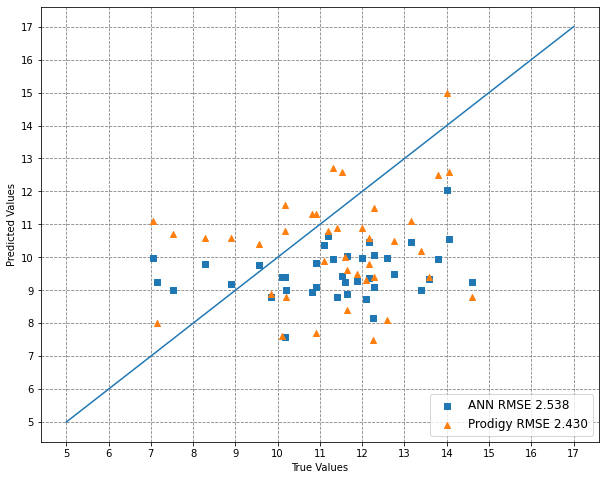

In [65]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(prodigy_score[' predicted'].to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

plt.show()

## PDBind

In [66]:
for i in range(umap_limit):

    PDBind_df = pd.read_csv("data/benchmark/validation.csv")
    PDBind_prodigy = pd.read_csv("data/benchmark/prodigy_PDBind.csv")

    # Remove pdb that wasn't accepted by prodigy
    PDBind_df.drop([24], axis=0, inplace=True)
    PDBind_prodigy.drop([24], axis=0, inplace=True)
    PDBind_df = PDBind_df.reset_index(drop=True)
    PDBind_prodigy = PDBind_prodigy.reset_index(drop=True)

    preds = []

    X_v = PDBind_df.drop(columns=['experimental',
                                  'packstat',
                                  'SCORE:',
                                  'yhh_planarity',
                                  'description'], axis=1).copy() 
    y_v = PDBind_df["experimental"].copy() 

    test_predictions = model.predict(X_v)

    test = y_v.to_numpy()

    rmse = \
        np.sqrt(mean_squared_error(test, test_predictions, squared=True))
    
    rmse_prodigy = \
        np.sqrt(mean_squared_error(test, PDBind_prodigy['predicted'].astype(float).to_numpy(), squared=True))

    print("RMSE score:", rmse)
    print("RMSE score PRODIGY:", rmse_prodigy)
    print("R2 score experimental vs ANN:",
          r2_score(test, test_predictions))
    print("R2 score experimental vs Prodigy:",
          r2_score(test, PDBind_prodigy['predicted'].astype(float).to_numpy()))
    print("Pearson correlation experimental vs ANN:",
          pearsonr(test, test_predictions)[0])
    print("Pearson correlation experimental vs Prodigy:",
          pearsonr(test, PDBind_prodigy['predicted'].astype(float).to_numpy())[0])
    
    preds.append((test_predictions, test))

    df_testV = pd.DataFrame(test)
    df_predV = pd.DataFrame(test_predictions)
    df_errorV = pd.DataFrame(test - test_predictions)
    df_prodigy = PDBind_prodigy['predicted'].astype(float)
    df_prodigy_error = pd.DataFrame(test - df_prodigy.to_numpy())
    df_comparison = pd.concat([df_testV, df_predV, df_errorV, df_prodigy, df_prodigy_error], axis=1)
    df_comparison.columns = ["REAL", "PREDICTED", "P_ERROR", "PRODIGY", "PRODIGY_ERROR"]
    print("\nDF COMPARISON:\n", df_comparison, "\n")

RMSE score: 2.616997805908951
RMSE score PRODIGY: 3.586044094109546
R2 score experimental vs ANN: -0.8605111234531895
R2 score experimental vs Prodigy: -2.4934682819686396
Pearson correlation experimental vs ANN: -0.0658584289196836
Pearson correlation experimental vs Prodigy: -0.08264119899508117

DF COMPARISON:
      REAL  PREDICTED    P_ERROR  PRODIGY  PRODIGY_ERROR
0  -10.50  -8.982403  -1.517597     -9.4          -1.10
1   -8.31  -9.557186   1.247186     -6.8          -1.51
2  -10.25  -7.422426  -2.827574     -7.3          -2.95
3   -9.17 -11.248815   2.078815    -13.4           4.23
4  -11.92 -12.230821   0.310821    -15.6           3.68
5   -8.95  -9.511346   0.561346     -7.7          -1.25
6   -9.55  -8.919154  -0.630846    -11.1           1.55
7  -10.85  -9.998720  -0.851280    -10.8          -0.05
8  -10.89  -9.073937  -1.816063     -7.7          -3.19
9  -13.06 -12.713754  -0.346246    -17.1           4.04
10 -11.31 -11.891361   0.581361    -12.7           1.39
11  -7.05 -1

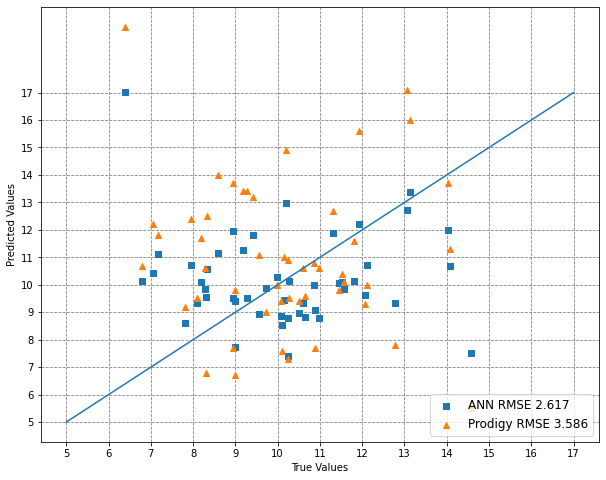

In [67]:
plt.figure(figsize=(10, 8))
ax = plt.axes()

simbols = ['s', '^']

# Article
ax.scatter(np.multiply(test, -1),
           np.multiply(test_predictions, -1), marker=simbols[0])

# Prodigy
ax.scatter(np.multiply(test, -1),
           np.multiply(PDBind_prodigy['predicted'].astype(float).to_numpy(), -1),
           marker=simbols[1])

plt.legend(
           (f'ANN RMSE {rmse:.3f}', f'Prodigy RMSE {rmse_prodigy:.3f}'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=12)
ax.plot(range(5, 18), range(5, 18))
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.xticks(range(5, 18))
plt.yticks(range(5, 18))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
